__Bipartite Graph Construction Based on Prototype:__
 * kmeans for prototyping ( select k prototypes)
 * construct Bipartite Graph based on Gaussian ( $ \sigma $ )
 * Laplacian and it's eigenvectors
 * new representation
 * test 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pylab as pl
%matplotlib inline

In [2]:
def generateTwoDisks():
    angle = np.arange(0, np.pi*2, 0.15)

    r1 = 50
    r2 = 20
    size = angle.shape[0]

    x1 = r1 * np.cos(angle)
    y1 = r1 * np.sin(angle)

    x2 = r2 * np.cos(angle)
    y2 = r2 * np.sin(angle)


    EACH = 10
    X = np.zeros(2*size*EACH)
    Y = np.zeros(2*size*EACH)
    label = np.zeros(2*size*EACH)
    label[size*EACH:] = np.ones(size*EACH)

    cov = [[5, 0], [0, 5]]  # diagonal covariance
    for i in range(size):
        X[i*EACH:(i+1)*EACH],Y[i*EACH:(i+1)*EACH] = np.random.multivariate_normal([x1[i],y1[i]], cov, EACH).T
        X[(i+size)*EACH:(i+size+1)*EACH],Y[(i+size)*EACH:(i+size+1)*EACH] = np.random.multivariate_normal([x2[i],y2[i]], cov, EACH).T
    return X,Y,label,"Disks"

def generateTwoGaussian():
    mean1 = [-2, -2]
    cov1 = [[1, 0], [0, 1]]  # diagonal covariance
    mean2 = [2,2]
    cov2 = [[1, 0], [0, 1]]  # diagonal covariance

    # data
    x = np.zeros(200)
    y = np.zeros(200)
    label = np.zeros(200)
    x[:100], y[:100] = np.random.multivariate_normal(mean1, cov1, 100).T
    x[100:], y[100:] = np.random.multivariate_normal(mean2, cov2, 100).T
    label[100:] = np.ones(100)
    return x,y,label,"Gaussian"

def generateTwoParabola():
    x1 = np.linspace(-10, 10, 40)
    y1 = .22*x1**2 + .024*x1 + .04  

    x2 = np.linspace(0, 20, 40)
    y2 = -.2*(x2-10)**2 - .024*(x2-10) + 35

    size = x1.shape[0]
    EACH = 10
    X = np.zeros(2*size*EACH)
    Y = np.zeros(2*size*EACH)
    label = np.zeros(2*size*EACH)
    label[size*EACH:] = np.ones(size*EACH)

    cov = [[1, 0], [0, 1]]  # diagonal covariance
    for i in range(size):
        X[i*EACH:(i+1)*EACH],Y[i*EACH:(i+1)*EACH] = np.random.multivariate_normal([x1[i],y1[i]], cov, EACH).T
        X[(i+size)*EACH:(i+size+1)*EACH],Y[(i+size)*EACH:(i+size+1)*EACH] = np.random.multivariate_normal([x2[i],y2[i]], cov, EACH).T
    return X,Y,label,"Parabolas"


def plotData(x,y,label,dataName):
    plt.plot(x[label==0], y[label==0], 'bo')
    plt.plot(x[label==1], y[label==1], 'ro')
    plt.axis('equal')
    plt.savefig(dataName+'.jpg')
    plt.show()
colors = ['b', 'g', 'r', 'w', 'y']
def plotData2(x,y,label,dataName):
    num = len(np.unique(sorted(label)))
    for i in range(num):
        plt.plot(x[label==i], y[label==i], colors[i%5]+'o')
    plt.axis('equal')
    plt.savefig(dataName+'.jpg')
    plt.show()

<h2 style="color:red"> __Prototyping__ </h2>

In [32]:
from sklearn.cluster import KMeans
def Prototyping(dataset,numP):
    kmeans = KMeans(init='k-means++',n_clusters=numP)
    kmeans.fit(dataset)

    print 'initiated clustered data:'
    plotData2(X,Y,kmeans.labels_,'a')

    centers = kmeans.cluster_centers_
    clu = kmeans.labels_
    a = np.zeros(numP,dtype=int)
    for i in range(len(clu)):
        a[clu[i]] += 1
    print a
    return centers


<h2 style="color:red"> Graph Construction </h2>

In [4]:



def distance2(p1,p2):
    return (p1[0]-p2[0])**2+(p1[1]-p2[1])**2
def similarity(p1,p2):
    sigma = 10
    return np.exp((-distance2(p1,p2)**2)/(2*(sigma**2)))


def constructBipartite(dataset,numS,centers,numP):
    N = numS + numP
    # constructing graph
    W = np.zeros((N,N))
    for i in range(numS):
        for j in range(numP):
            W[i,j+numS] = similarity((dataset[i,0],dataset[i,1]),(centers[j,0],centers[j,1]))
            W[j+numS,i] = W[i,j+numS]

    # construct laplacian
    D = np.diag(np.dot(W,np.ones(N)))
    L = D - W
    return W,D,L

def constructSupervised(dataset,numS,centers,numP,labels):
    labelNodes = np.unique(sorted(labels))
    p1 = np.sum(labels)
    p0 = labels.shape[0] - p1
    P = [ 1.0/p0, 1.0/p1] 
    N = numS + numP + len(labels)
    # constructing graph
    W = np.zeros((N,N))
    for i in range(numS):
        for j in range(numP):
            W[i,j+numS] = similarity((dataset[i,0],dataset[i,1]),(centers[j,0],centers[j,1]))
            W[j+numS,i] = W[i,j+numS]

    for i in range(numS):
        W[i,numS+numP+labels[i]] = P[labels[i]]
        W[numS+numP+labels[i],i] = P[labels[i]]
    # construct laplacian
    D = np.diag(np.dot(W,np.ones(N)))
    L = D - W
    return W,D,L


<h2 style="color:red">__unnormalized laplacian method (1)__</h2>

In [5]:
def unnormalized(W,D,L):
    # find eigenvectors and eigenvalues
    eigenValues , eigenVectors = np.linalg.eig(L)
    idx = eigenValues.argsort()
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues,eigenVectors

<h2 style="color:red">__normalized laplacian method - Shi & Malik (2)__</h2>

In [6]:
import scipy as sp
def normalized2(W,D,L):
    N = W.shape[0]
    D = np.diag(np.dot(W,np.ones(N)))
    L = D - W
    eigenValues , eigenVectors = sp.linalg.eig(L,D)
    eigenValues = eigenValues.real
    idx = eigenValues.argsort()
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues,eigenVectors

<h2 style="color:red">__normalized laplacian method - Ng & Jordan (2)__</h2>

In [7]:
def normalized3(W,D,L):
    N = W.shape[0]
    d = np.diag(D)
    d1 = 1/np.sqrt(d)
    D1 = np.diag(d1)
    Lsym = np.dot(np.dot(D1,L),D1)
    for i in range(D1.shape[0]):
        print D1[i,i],
#     for i in range(Lsym.shape[0]):
#         for j in range(Lsym.shape[1]):
#             print Lsym[i,j],
#         print
    print Lsym
    eigenValues , eigenVectors = np.linalg.eig(Lsym)
    eigenValues = eigenValues.real
    idx = eigenValues.argsort()
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues,eigenVectors

In [8]:
def eigPlot(eigenValues,eigenVectors,label,model):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    N = eigenValues.shape[0]
    #1
    eig0 = (eigenVectors[:,0])[label == 0]
    eig1 = (eigenVectors[:,0])[label == 1]
    ax1.plot(range(len(eig0)),eig0,'bx')
    ax1.plot(range(len(eig0),N),eig1,'rx')
    ax1.text(.5,.9,'1st eigenVector',
            horizontalalignment='center',
            transform=ax1.transAxes)
    #2
    eig0 = (eigenVectors[:,1])[label == 0]
    eig1 = (eigenVectors[:,1])[label == 1]
    ax2.plot(range(len(eig0)),eig0,'bx')
    ax2.plot(range(len(eig0),N),eig1,'rx')
    ax2.text(.5,.9,'2nd eigenVector',
            horizontalalignment='center',
            transform=ax2.transAxes)
    #3
    eig0 = (eigenVectors[:,2])[label == 0]
    eig1 = (eigenVectors[:,2])[label == 1]
    ax3.plot(range(len(eig0)),eig0,'bx')
    ax3.plot(range(len(eig0),N),eig1,'rx')
    ax3.text(.5,.9,'3rd eigenVector',
            horizontalalignment='center',
            transform=ax3.transAxes)
    #4
    eig0 = (eigenVectors[:,3])[label == 0]
    eig1 = (eigenVectors[:,3])[label == 1]
    ax4.plot(range(len(eig0)),eig0,'bx')
    ax4.plot(range(len(eig0),N),eig1,'rx')
    ax4.text(.5,.9,'4th eigenVector',
            horizontalalignment='center',
            transform=ax4.transAxes)
    
    plt.savefig('eigenVectos '+model+'.jpg')
    plt.show()
    xt = eigenVectors[:,0]
    yt = eigenVectors[:,1]
    plt.plot(xt[label==0], yt[label==0], 'bo')
    plt.plot(xt[label==1], yt[label==1], 'ro')

    plt.title('new representation 2 '+model)
    plt.savefig('new representation 2 '+model+'.jpg')
    plt.show()
    
    
    xt = eigenVectors[:,2]
    yt = eigenVectors[:,3]
    plt.plot(xt[label==0], yt[label==0], 'bo')
    plt.plot(xt[label==1], yt[label==1], 'ro')

    plt.title('new representation '+model)
    plt.savefig('new representation '+model+'.jpg')
    plt.show()
    

    plt.plot(range(10),eigenValues[:10],'bo')
    plt.title('eigenValues '+model)
    
    plt.savefig('eigenValues '+model+'.jpg')
    plt.show()
    print eigenValues[:10]

<h1 style="color:purple">__Results__</h2>

<h2 style="color:red">__Two Gaussian__</h2>

first data:


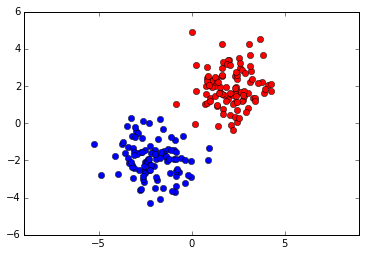

initiated clustered data:


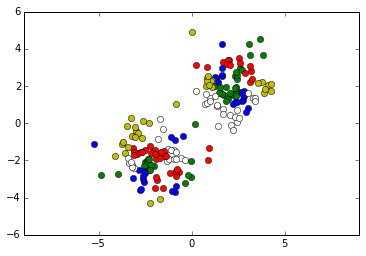

[ 2  7  9 10  7 11  6  4  8  3  1  4  5  8  5  6 11  2  3  1  1  2 11  2  8
  3 10  5  1  7  7  4  7  6  1  3  1  2  4  2]
prototypes


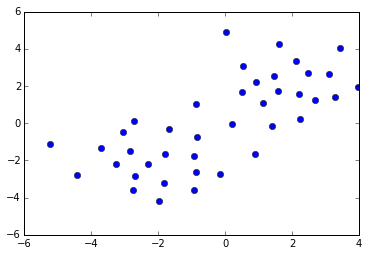

In [33]:
#prototyping
numP = 40


X,Y,label,name = generateTwoGaussian() #generateTwoDisks()
print 'first data:'
plotData(X,Y,label,name)

dataset = np.array([X, Y]).T
centers = Prototyping(dataset,numP)

print 'prototypes'
plt.plot(centers[:,0],centers[:,1],'bo')


numS = dataset.shape[0]
N = numS + numP


<h2 style="color:red">__Unnormalized Results__</h2>

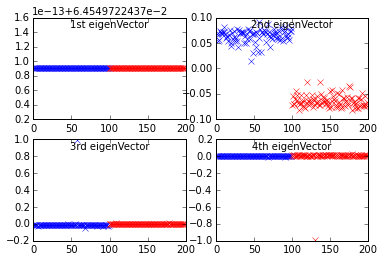

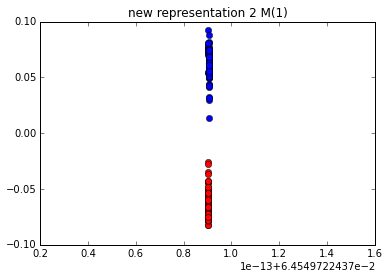

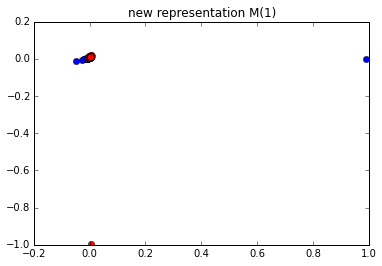

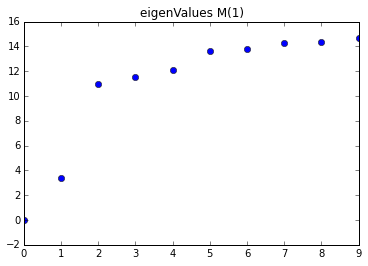

[ -7.50192247e-14   3.40530685e+00   1.09581917e+01   1.15240556e+01
   1.21181251e+01   1.36414005e+01   1.37754652e+01   1.43033089e+01
   1.43847103e+01   1.46416452e+01]


In [10]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = unnormalized(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

<h2 style="color:red">__Normalized Results__</h2>

0.22544530735 0.230159076595 0.23816931375 0.2217004596 0.225557165417 0.23973287114 0.258417569433 0.233566486856 0.230050936534 0.2333222966 0.232599637074 0.261414720413 0.228535030964 0.225969742837 0.231950545575 0.226108713029 0.223262602553 0.227042708828 0.241683876539 0.220070922894 0.2201878091 0.237275209166 0.223526520864 0.227742050089 0.252958427105 0.221455156781 0.224478927553 0.224002884121 0.251275403305 0.218623482699 0.255128592793 0.259141053647 0.231568378855 0.235987787574 0.234704190711 0.236166997344 0.231531538801 0.230910483167 0.226226652973 0.243488552643 0.224793031984 0.242336966073 0.251554313506 0.238442029038 0.223703134426 0.241782169624 0.21784503986 0.236303061903 0.238816741434 0.254687426172 0.234952189468 0.221925975428 0.244587260124 0.220616623122 0.232104797436 0.215394420273 0.224945388789 0.302408416835 0.252463291938 0.214475882658 0.232518754364 0.234932329812 0.230605359701 0.240853719118 0.249353351146 0.236656773658 0.221215215065 0.251

c:\Anaconda\lib\site-packages\numpy\core\numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


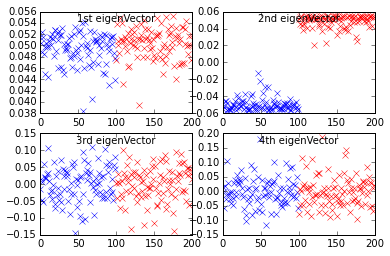

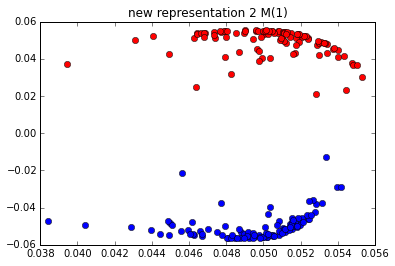

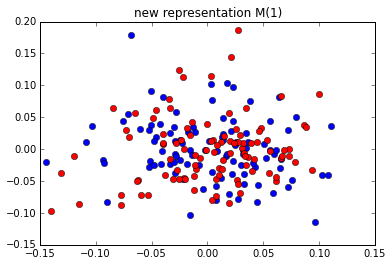

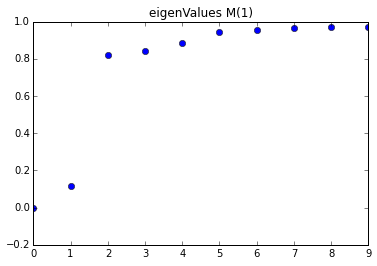

[ -1.10232978e-16   1.16189035e-01   8.22986623e-01   8.41934431e-01
   8.86131100e-01   9.45615339e-01   9.56538219e-01   9.64513692e-01
   9.71245265e-01   9.73039752e-01]


In [11]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = normalized3(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

<h2 style="color:red">__Two Disks__</h2>


first data:


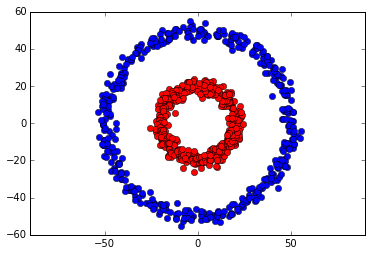

initiated clustered data:


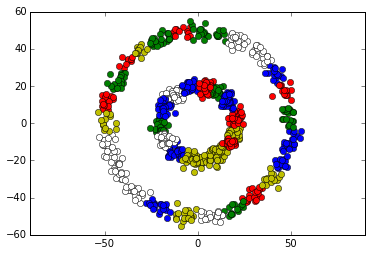

prototypes


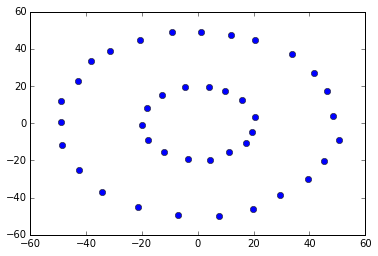

In [12]:
#prototyping
numP = 40

from sklearn.cluster import KMeans
X,Y,label,name = generateTwoDisks()
print 'first data:'
plotData(X,Y,label,name)

dataset = np.array([X, Y]).T
centers = Prototyping(dataset,numP)

print 'prototypes'
plt.plot(centers[:,0],centers[:,1],'bo')


numS = dataset.shape[0]
N = numS + numP

<h2 style="color:red">__Unnormalized Results__</h2>

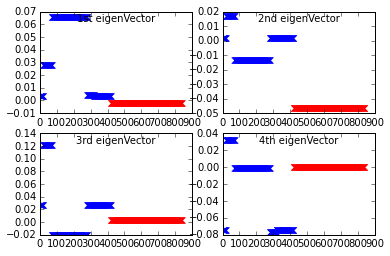

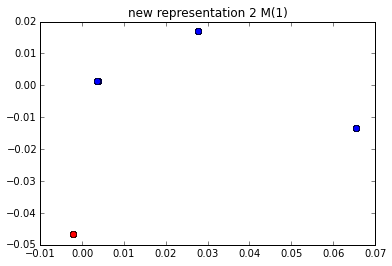

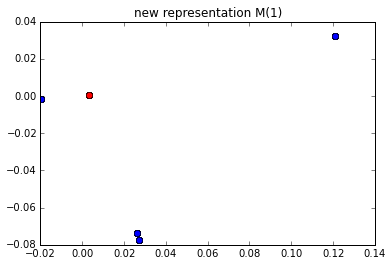

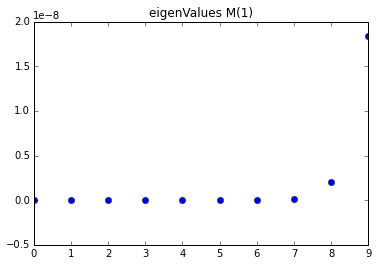

[ -5.71421378e-16   1.11022307e-16   4.03138388e-16   1.03925454e-15
   7.07733607e-14   9.35618911e-13   3.52093774e-11   1.41873752e-10
   2.01454010e-09   1.84085066e-08]


In [13]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = unnormalized(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

<h2 style="color:red">__Normalized Results__</h2>

1.70677730028 3.2471851686 1.31778744879 213.887598259 1.3378372502 5.28478168247 1.17937676985 1.06991265504 1.04106356162 3.9050853419 1.0298014255 1.47921899883 1.72796744734 1.37425504075 1.48786269883 1.25758136259 2.11296737441 1.39876499328 3.27564070964 6.14753212683 1.06798494524 1.08031740001 1.00043446397 1.00525155932 1.09156224266 22.5149161678 1.69411485272 1.01421611192 1.00191092003 1.00147992343 1.54309841142 14.101327038 6.46187644112 1.57200738964 1.36808256651 508.497475 1.04088040541 5.46278130366 2.27503604429 1.84744584252 1.0018137766 1.03319238802 1.00023926437 1.00412355424 1.38995443985 1.68494637083 1.09159980439 11.0365596554 2.47635094961 1.00660985499 1.14165192543 1.61753443961 23.809842123 3.59928857757 1.09898783201 7.07221317126 129.415073688 6.2768079705 6.60856265014 1.00345122715 2.02134004025 5.28285479931 1.74258479106 2.44734778051 1.5864283385 5.69737253891 1.13271161049 10.6828420773 1.06253833177 1.95329486532 1.40226960794 10.1537454798 5.15

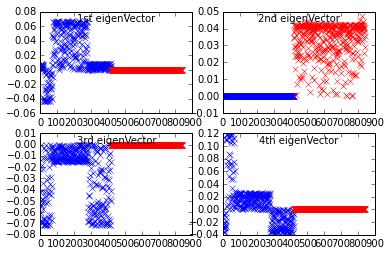

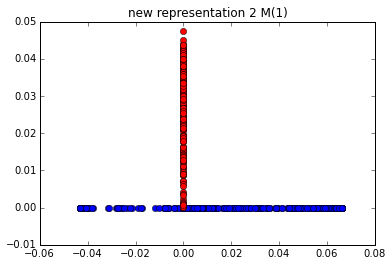

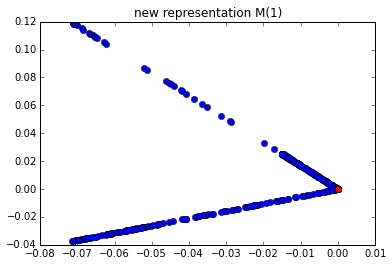

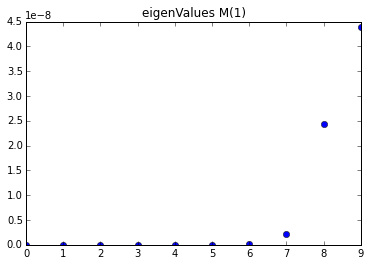

[  2.18485509e-16   4.18865496e-16   4.33683968e-16   9.55713955e-16
   8.51841562e-14   4.15094196e-11   1.44212821e-10   2.27624939e-09
   2.43885113e-08   4.39135928e-08]


In [14]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = normalized3(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

<h2 style="color:red">__Two Parabolas__</h2>


first data:


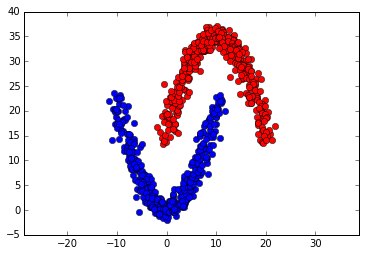

initiated clustered data:


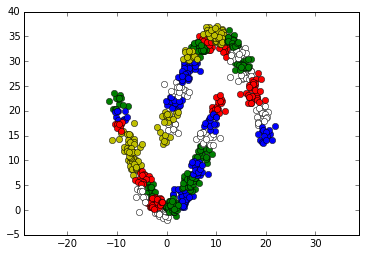

prototypes


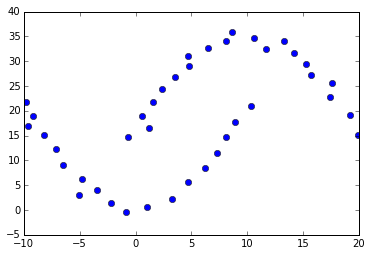

In [15]:
#prototyping
numP = 40

from sklearn.cluster import KMeans
X,Y,label,name = generateTwoParabola()
print 'first data:'
plotData(X,Y,label,name)

dataset = np.array([X, Y]).T
centers = Prototyping(dataset,numP)

print 'prototypes'
plt.plot(centers[:,0],centers[:,1],'bo')


numS = dataset.shape[0]
N = numS + numP

<h2 style="color:red">__Unnormalized Results__</h2>

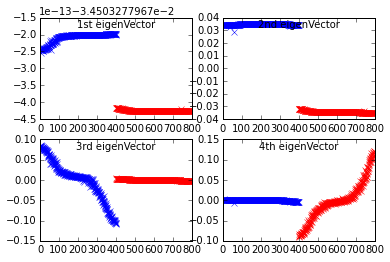

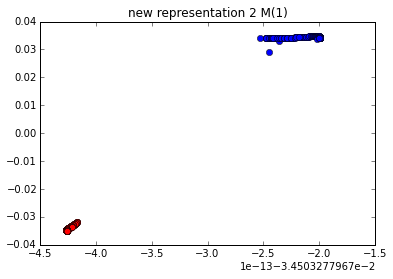

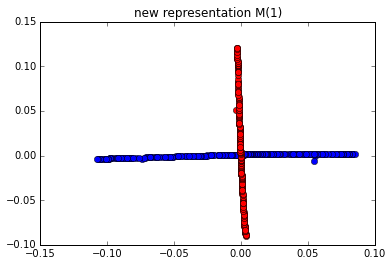

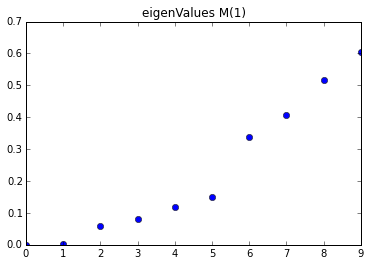

[  1.07384804e-14   9.95354599e-04   5.84890562e-02   8.05606123e-02
   1.19616734e-01   1.50617491e-01   3.39495911e-01   4.05974131e-01
   5.18145385e-01   6.03544376e-01]


In [16]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = unnormalized(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

<h2 style="color:red">__Normalized Results__</h2>

0.698997941955 0.904534226753 0.83470015064 0.817137876952 0.842542339415 0.866035649498 1.01571960515 0.655767886113 0.613392295589 0.843744181934 0.593227386401 0.611809541374 0.631947493974 0.619601460333 0.578238916912 0.580090314694 0.719876233744 0.702123819704 0.636144121087 0.63297345509 0.581662607226 0.595424583019 0.582944207887 0.584297136999 0.613098845212 0.588705089425 0.59244438221 0.60841341757 0.605681574176 0.578336827606 0.587127130227 0.640221311628 0.686623551941 0.594688262449 0.603299541286 0.623311277497 0.598266116586 0.597695682249 0.587397206538 0.845520820886 0.758646129854 0.656909871934 0.668349653304 0.609036167926 0.703400242049 0.678242741089 0.679071131467 0.633936778018 0.68983245596 0.65736421376 0.669890224063 0.667895251178 0.6791838687 0.674219657255 0.676954134321 0.689296686976 0.669844007899 0.693442402401 0.813722798404 0.715390641417 0.694952638854 0.676776141537 0.717533286267 0.706239653042 0.681647730215 0.676628416356 0.707357419454 0.68

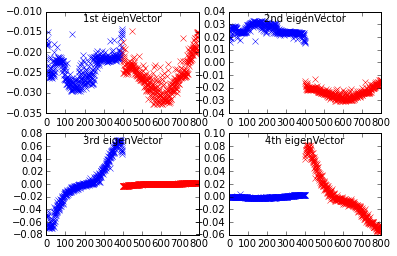

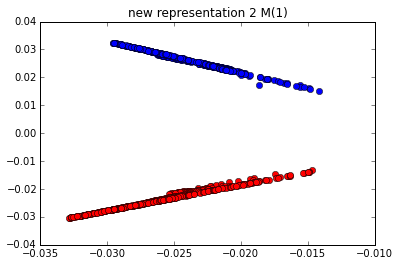

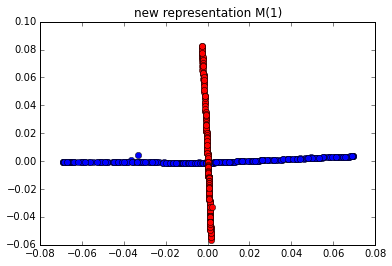

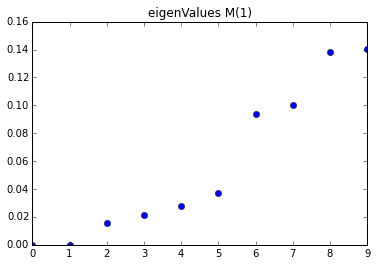

[  1.64786533e-15   1.93953847e-04   1.55910387e-02   2.12369183e-02
   2.78923036e-02   3.68704991e-02   9.41108091e-02   1.00236335e-01
   1.38088458e-01   1.40408682e-01]


In [17]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = normalized3(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

<b style="color:red">----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

In [18]:
def eigPlot2(eigenValues,eigenVectors,label,model):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    N = eigenValues.shape[0]
    #1
    eig0 = (eigenVectors[:,0])[label == 0]
    eig1 = (eigenVectors[:,0])[label == 1]
    ax1.plot(range(len(eig0)),eig0,'bx')
    ax1.plot(range(len(eig0),len(eig0)+len(eig1)),eig1,'rx')
    ax1.text(.5,.9,'1st eigenVector',
            horizontalalignment='center',
            transform=ax1.transAxes)
    #2
    eig0 = (eigenVectors[:,1])[label == 0]
    eig1 = (eigenVectors[:,1])[label == 1]
    ax2.plot(range(len(eig0)),eig0,'bx')
    ax2.plot(range(len(eig0),len(eig0)+len(eig1)),eig1,'rx')
    ax2.text(.5,.9,'2nd eigenVector',
            horizontalalignment='center',
            transform=ax2.transAxes)
    #3
    eig0 = (eigenVectors[:,2])[label == 0]
    eig1 = (eigenVectors[:,2])[label == 1]
    ax3.plot(range(len(eig0)),eig0,'bx')
    ax3.plot(range(len(eig0),len(eig0)+len(eig1)),eig1,'rx')
    ax3.text(.5,.9,'3rd eigenVector',
            horizontalalignment='center',
            transform=ax3.transAxes)
    #4
    eig0 = (eigenVectors[:,3])[label == 0]
    eig1 = (eigenVectors[:,3])[label == 1]
    ax4.plot(range(len(eig0)),eig0,'bx')
    ax4.plot(range(len(eig0),len(eig0)+len(eig1)),eig1,'rx')
    ax4.text(.5,.9,'4th eigenVector',
            horizontalalignment='center',
            transform=ax4.transAxes)
    
    plt.savefig('eigenVectos '+model+'.jpg')
    plt.show()
    xt = eigenVectors[:,0]
    yt = eigenVectors[:,1]
    plt.plot(xt[label==0], yt[label==0], 'bo')
    plt.plot(xt[label==1], yt[label==1], 'ro')

    plt.title('new representation 2 '+model)
    plt.savefig('new representation 2 '+model+'.jpg')
    plt.show()
    
    
    xt = eigenVectors[:,2]
    yt = eigenVectors[:,3]
    plt.plot(xt[label==0], yt[label==0], 'bo')
    plt.plot(xt[label==1], yt[label==1], 'ro')

    plt.title('new representation '+model)
    plt.savefig('new representation '+model+'.jpg')
    plt.show()
    

    plt.plot(range(10),eigenValues[:10],'bo')
    plt.title('eigenValues '+model)
    
    plt.savefig('eigenValues '+model+'.jpg')
    plt.show()
    print eigenValues[:10]

In [44]:
def generateTwoDisksOutlier():
    angle = np.arange(0, np.pi*2, 0.15)

    r1 = 50
    r2 = 20
    size = angle.shape[0]

    x1 = r1 * np.cos(angle)
    y1 = r1 * np.sin(angle)

    x2 = r2 * np.cos(angle)
    y2 = r2 * np.sin(angle)

    OutlierNum = 60
    EACH = 10
    X = np.zeros(2*size*EACH+OutlierNum)
    Y = np.zeros(2*size*EACH+OutlierNum)
    label = np.ones(2*size*EACH+OutlierNum)
    label[size*EACH:2*size*EACH] = np.zeros(size*EACH)

    cov = [[5, 0], [0, 5]]  # diagonal covariance
    for i in range(size):
        X[i*EACH:(i+1)*EACH],Y[i*EACH:(i+1)*EACH] = np.random.multivariate_normal([x1[i],y1[i]], cov, EACH).T
        X[(i+size)*EACH:(i+size+1)*EACH],Y[(i+size)*EACH:(i+size+1)*EACH] = np.random.multivariate_normal([x2[i],y2[i]], cov, EACH).T
    cov2 = [[1000,0],[0,1000]]
    X[2*size*EACH:],Y[2*size*EACH:] = np.random.multivariate_normal([0,0], cov2, OutlierNum).T
    label[2*size*EACH:] *= 2
    return X,Y,label,"Disks"

first data:


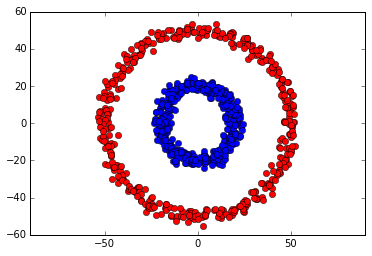

initiated clustered data:


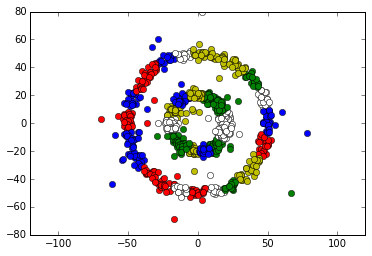

[20 40 20 22 34 20 28 23 15 21 25 26 26 43 29 28 20 21 38 10 22 36 20  1 22
 40  1 18 39 21  1 34  1 15 35 24 16 15 13 17]
prototypes


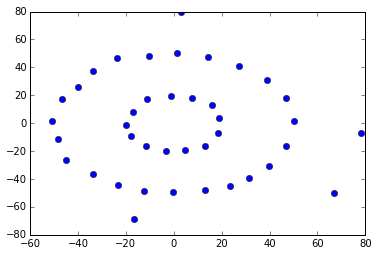

In [45]:
#prototyping
numP = 40

from sklearn.cluster import KMeans
X,Y,label,name = generateTwoDisksOutlier()
print 'first data:'
plotData(X,Y,label,name)

dataset = np.array([X, Y]).T
centers = Prototyping(dataset,numP)

print 'prototypes'
plt.plot(centers[:,0],centers[:,1],'bo')


numS = dataset.shape[0]
N = numS + numP

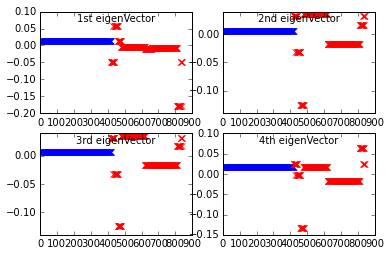

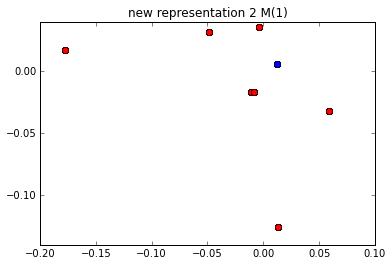

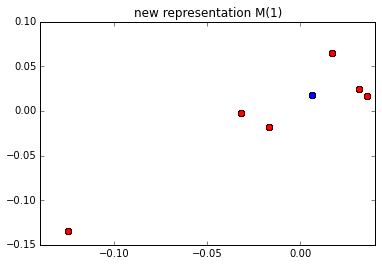

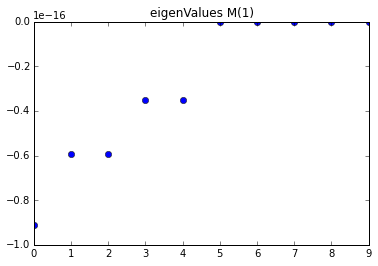

[ -9.12323705e-17 +0.00000000e+00j  -5.91315551e-17 -1.20008466e-16j
  -5.91315551e-17 +1.20008466e-16j  -3.50745284e-17 -3.99340201e-17j
  -3.50745284e-17 +3.99340201e-17j  -5.66425299e-21 -2.32136749e-21j
  -5.66425299e-21 +2.32136749e-21j  -4.14208962e-21 +0.00000000e+00j
  -2.20604178e-21 -7.44460225e-21j  -2.20604178e-21 +7.44460225e-21j]


In [46]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = unnormalized(W,D,L)
eigPlot2(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

In [47]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = normalized3(W,D,L)
eigPlot2(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

1.66917365893 1.59931880354 1.08963783323 1.10348855535 1.010439133 1.84070360783 1.06152941445 1.00589421599 1.00394255033 1.58386660601 5935.62952376 585.047749625 1540.58930883 3.02453063982 44.0998994185 285.680213273 2.29644773096 10178.8550135 260027.915994 1.69019732668 2.24300034259 1.20897614463 5.20641544237 1.11968042903 7.9622054591 1.02999567982 1.6242221929 1.17063158716 1.13646537716 6.88594937331 6.3775598338 1.13135395947 2.73525416184 9.91592432702 3.17732868761 2.81334182573 3.02470001399 1.03893061041 18.8614504624 24.1799702666 1.00985625941 2.73043565288 46.4218797995 1.16899684337 1.01278289914 1.04739897255 1.01227943745 12.6155046732 2.59071156503 1.09040924603 34.0325056645 1.11039568558 20.2390139153 3.8719995078 21.5798844769 1.71429554091 48.8098902891 5.0538493537 1.32465267692 1.04872733716 10.6748601384 1.07625084691 1.05215461062 15.846869537 1.04817684951 25.6200739875 67.5786253496 1.00519507729 3.31325958233 2.50252688156 1.2424345157 1.34554659495 1

LinAlgError: Array must not contain infs or NaNs

In [48]:
def generateTwoDisksOutlier2():
    angle = np.arange(0, np.pi*2, 0.15)

    r1 = 50
    r2 = 20
    size = angle.shape[0]

    x1 = r1 * np.cos(angle)
    y1 = r1 * np.sin(angle)

    x2 = r2 * np.cos(angle)
    y2 = r2 * np.sin(angle)

    OutlierNum = 60
    EACH = 10
    X = np.zeros(2*size*EACH+OutlierNum)
    Y = np.zeros(2*size*EACH+OutlierNum)
    label = np.ones(2*size*EACH+OutlierNum)
    label[size*EACH:2*size*EACH] = np.zeros(size*EACH)

    cov = [[5, 0], [0, 5]]  # diagonal covariance
    for i in range(size):
        X[i*EACH:(i+1)*EACH],Y[i*EACH:(i+1)*EACH] = np.random.multivariate_normal([x1[i],y1[i]], cov, EACH).T
        X[(i+size)*EACH:(i+size+1)*EACH],Y[(i+size)*EACH:(i+size+1)*EACH] = np.random.multivariate_normal([x2[i],y2[i]], cov, EACH).T
    cov2 = [[1000,0],[0,1000]]
    X[2*size*EACH:],Y[2*size*EACH:] = np.random.multivariate_normal([0,0], cov2, OutlierNum).T
    label[2*size*EACH:] *= 2
    return X,Y,label,"Disks"

first data:


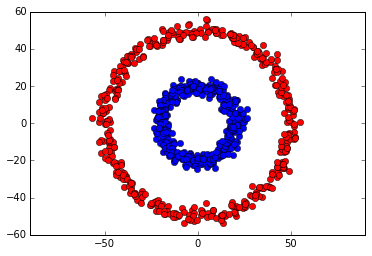

initiated clustered data:


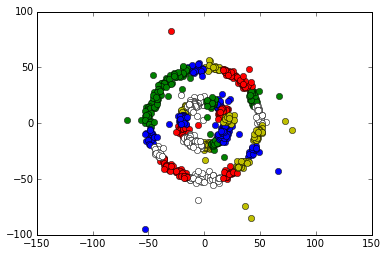

[27 17 44 21 20 22 25 21 31 27 20 22 21 23 27 28 22 21 22 25 22 25  1 21  2
  1 31 22 28 20 29 16 20 33  2 33 28 25 31 24]
prototypes


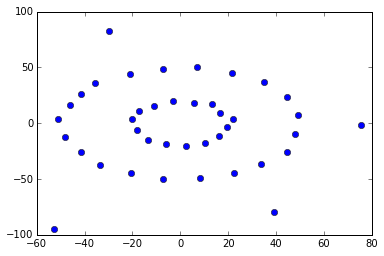

In [49]:
#prototyping
numP = 40

from sklearn.cluster import KMeans
X,Y,label,name = generateTwoDisksOutlier()
print 'first data:'
plotData(X,Y,label,name)

dataset = np.array([X, Y]).T
centers = Prototyping(dataset,numP)

print 'prototypes'
plt.plot(centers[:,0],centers[:,1],'bo')


numS = dataset.shape[0]
N = numS + numP

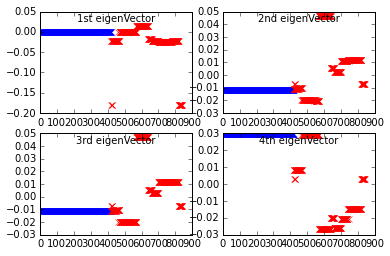

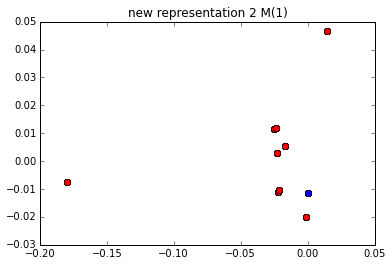

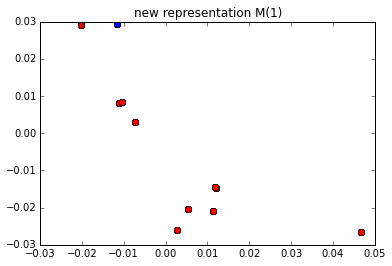

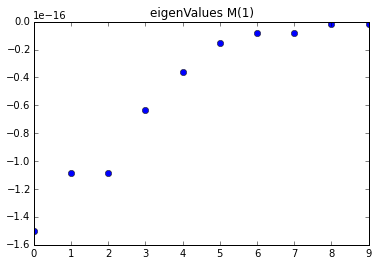

[ -1.50094535e-16 +0.00000000e+00j  -1.08565845e-16 -1.83233875e-17j
  -1.08565845e-16 +1.83233875e-17j  -6.31057872e-17 +0.00000000e+00j
  -3.61759002e-17 +0.00000000e+00j  -1.53479001e-17 +0.00000000e+00j
  -8.17999172e-18 -3.35140044e-17j  -8.17999172e-18 +3.35140044e-17j
  -1.60307555e-18 -1.71388346e-17j  -1.60307555e-18 +1.71388346e-17j]


In [50]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = unnormalized(W,D,L)
eigPlot2(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

In [40]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = normalized3(W,D,L)
eigPlot2(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

1.00888315858 1.93825316424 2.20582319747 1.0069523174 1.00108028811 1.20315327861 1.00693711315 1.24021672254 1.5584072029 1.10733575831 2.80130026474 5.82335080667 1.33438505618 2.66057987336 1.05022545581 6.96090493019 1.003234702 34.4935293287 2.86896118625 3.94314061002 16.7198623492 14.8142215503 1.49312442951 2.30486759303 1.35668771497 10.9585711335 1.21829590525 1.04530288665 4.65376072193 1.35746127415 1.01235592779 1.06370242715 1.00083602486 1.01914982742 1.01863026819 1.08204393085 1.33341469153 60.9012253718 1.20914022192 1.00000046365 1.48621521123 5.39856495641 2.03052344674 2.67179515148 1.01480035216 1.03296932067 7.10504179086 1.00006664039 1.00015853167 3.29859506428 23.2390531648 1.52205984867 1.04081150871 15.563036787 1.01427574579 2.20493229112 24.9451703301 2.45200166067 1.07899617166 1.3886978303 2.65444300415 1.1398090883 1.01331739095 1.69082135643 1.01112880347 1.02192802325 1.48236072344 1.17161099859 6.96017931519 2.06281953325 2.74043667393 1.65700682849

LinAlgError: Array must not contain infs or NaNs